# Process NGC 4380's $\rm H\alpha$ data from VESTIGE

Isaac Cheng - December 2021

Based on [`NGC4380_Halpha.ipynb`](../../galaxies/NGC4380/NGC4380_Halpha.ipynb).


In [1]:
# 
# Switch directories to folder for galaxy.
# Will contain relevant pickle files for the galaxy
# 
GALAXY = "NGC4380"  # change this to the galaxy you want to Voronoi bin
GALPATH = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{GALAXY}/"  # change this path
%cd "$GALPATH"
# 
import astropy.units as u
import dill
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
from numba import njit, prange
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")  # change this path
import fits_utils as fu
import plot_utils as pu
from radial_profile import RadialProfile
# 
GALDIST = 16.5 * u.Mpc  # distance to centre of Virgo cluster. Assume 10% uncertainty

/arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380


## 1. Voronoi Binning

(Only need to do this once. If complete, can skip to the next step)


In [2]:
SNR_TARGET = 50  # specifies the vorbin pickle file to use
# 
# Load Halpha data
# 
Halpha_path = f"/arc/home/IsaacCheng/coop_f2021/vestige_data/{GALAXY}_Ha_NET_flux.fits"
Halpha_data_full, Halpha_header_full = fits.getdata(Halpha_path, header=True)
# 
# VERTICO CO Data (only to cut out the NGVS data to the same extent as the VERTICO data)
# 
# 9 arcsec beam, 2 arcsec pixels. Units of K.km/s
Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{GALAXY}/{GALAXY}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
Ico_data, co_header = fits.getdata(Ico_path, header=True)
co_wcs = WCS(co_header)
# 
# Load NGVS Voronoi-binned data
# 
with open(GALPATH + f"{GALAXY}_vorbin_SNR{SNR_TARGET}_ugizBinned.pkl", "rb") as f:
    file = dill.load(f)
    ngvs_data = file["uband_signal"]
    ngvs_wcs = file["wcs"]
    ngvs_wcs.array_shape = file["wcs_array_shape"]
    px_per_bin = file["px_per_bin"]
    binNum = file["binNum"]
    binNum_arr = file["binNum_arr"]
    file = None  # free memory
# 
# Cutout the Halpha data to the same extent as the VERTICO data
# 
Halpha_data_cut, Halpha_wcs_cut = fu.cutout_to_target(Halpha_data_full, WCS(Halpha_header_full), Ico_data, co_wcs)
print("VESTIGE cutout array shape:", Halpha_data_cut.shape)
print("NGVS vorbin image dimensions:", ngvs_data.shape)
# 
# Reproject Halpha data to match pixel dimensions of NGVS data
# 
# Halpha_data, Halpha_wcs = fu.reproject_arr_to_shape(Halpha_data_cut, Halpha_wcs_cut, ngvs_data.shape, print_debug=True)
Halpha_data = reproject_interp(
    (Halpha_data_cut, Halpha_wcs_cut), ngvs_wcs, shape_out=ngvs_data.shape, return_footprint=False
)
Halpha_wcs = ngvs_wcs.deepcopy()
print("VESTIGE reprojected cutout array shape:", Halpha_data.shape)
# 
# Mask Halpha data wherever the NGVS data are masked
# 
Halpha_data[~np.isfinite(ngvs_data)] = np.nan

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


VESTIGE cutout array shape: (861, 862)
NGVS vorbin image dimensions: (862, 861)
VESTIGE reprojected cutout array shape: (862, 861)


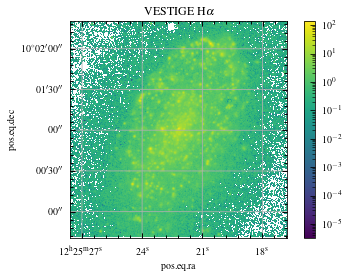

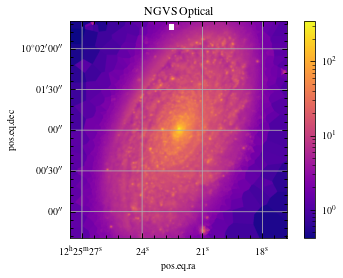

In [3]:
# 
# View final arrays as visual check that data are correct
# 
fig, ax = plt.subplots(subplot_kw={"projection": Halpha_wcs})
img = ax.imshow(Halpha_data, norm=mpl.colors.LogNorm(), cmap="viridis")
cbar = fig.colorbar(img)
ax.set_title(r"VESTIGE $\rm H\alpha$")
plt.show()
# 
fig, ax = plt.subplots(subplot_kw={"projection": ngvs_wcs})
img = ax.imshow(ngvs_data / px_per_bin, norm=mpl.colors.LogNorm(), cmap="plasma")
cbar = fig.colorbar(img)
ax.set_title(r"NGVS Optical")
plt.show()

Bin the Halpha data according to the Voronoi bins


In [4]:
@njit(parallel=True)
def fast_binning(arr, flat_binNum_arr, flat_binNum):
    """
    Note that all arrays must be 1D. Also, each entry in flat_binNum should be
    unique
    """
    arr_binned = np.full(arr.size, np.nan)
    # for i in flat_binNum:
    for i in prange(flat_binNum.max() + 1):
        bin_idx = flat_binNum_arr == i  # all of these pixels are in the same bin
        arr_binned[bin_idx] = np.nansum(arr[bin_idx])
    return arr_binned

# Run function above once to JIT-compile it
tmp_stuff = np.arange(50, dtype=float)
tmp_binNum_arr = np.array(list(np.arange(10)) * 5).astype(int)
tmp_binNum = np.arange(10).astype(int)
tmp_stuff_binned = fast_binning(tmp_stuff, tmp_binNum_arr, tmp_binNum)

In [5]:
#
# Bin the data and noise according to the Voronoi bins
#
print("Assigning SNRs to bins")
Halpha_data_vorbinned = fast_binning(
    Halpha_data.flatten(),
    binNum_arr.astype(int).flatten(),
    np.unique(binNum).astype(int).flatten(),
)
Halpha_data_vorbinned = Halpha_data_vorbinned.reshape(Halpha_data.shape)
# 
# Pickle the results
# 
vorbinned_results_outfile = GALPATH + f"{GALAXY}_vorbin_SNR{SNR_TARGET}_HalphaBinned.pkl"
with open(vorbinned_results_outfile, "wb") as f:
    dill.dump(
        {
            "wcs": Halpha_wcs,
            "wcs_array_shape": Halpha_wcs.array_shape,
            "vorbin_Halpha": Halpha_data_vorbinned,
            "snr_target": SNR_TARGET,  # float or int
            "px_per_bin": px_per_bin,  # 2D array with same shape as coords/signal/noise
            "binNum": binNum,  # 1D array returned by vorbin. Only contains "good" pixels
            "binNum_arr": binNum_arr,  # 2D array with same shape as coords/signal/noise
        },
        f,
    )
print(f"Pickled {vorbinned_results_outfile}")

Assigning SNRs to bins
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_vorbin_SNR50_HalphaBinned.pkl


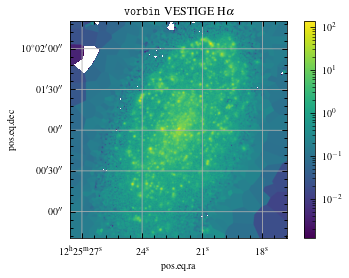

In [6]:
# 
# View binned Halpha data (log scale)
# 
fig, ax = plt.subplots(subplot_kw={"projection": Halpha_wcs})
img = ax.imshow(Halpha_data_vorbinned / px_per_bin, norm=mpl.colors.LogNorm(), cmap="viridis")
cbar = fig.colorbar(img)
ax.set_title(r"\texttt{vorbin} VESTIGE $\rm H\alpha$")
plt.show()

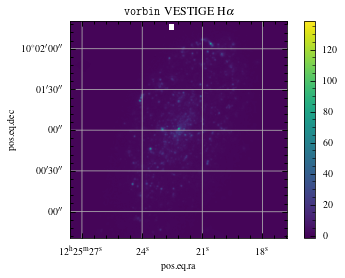

In [7]:
# 
# View binned Halpha data (linear scale)
# 
fig, ax = plt.subplots(subplot_kw={"projection": Halpha_wcs})
img = ax.imshow(Halpha_data_vorbinned / px_per_bin, cmap="viridis")
cbar = fig.colorbar(img)
ax.set_title(r"\texttt{vorbin} VESTIGE $\rm H\alpha$")
plt.show()

## 2. Radial Profiles


Load data required for radial profile of Halpha data


In [2]:
import re
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

In [3]:
SNR_TARGET = 50  # specifies which voronoi binning file to use
#
# Load Halpha data
#
Halpha_results = GALPATH + f"{GALAXY}_vorbin_SNR{SNR_TARGET}_HalphaBinned.pkl"
with open(Halpha_results, "rb") as f:
    file = dill.load(f)
    Halpha_unNormed_data = file["vorbin_Halpha"]
    Halpha_wcs = file["wcs"]
    Halpha_wcs.array_shape = file["wcs_array_shape"]
    px_per_bin = file["px_per_bin"]
# Normalize Halpha data by # pixels in each Voronoi bin
Halpha_data = Halpha_unNormed_data / px_per_bin
# 
# Get Halpha density (counts per square parsec)
# 
px_dimensions = fu.calc_pc_per_px(Halpha_wcs, GALDIST)[0]  # pc
px_area = px_dimensions[0] * px_dimensions[1]  # pc^2
Halpha_density = Halpha_data / px_area
# 
# Galaxy data from Table 1 of Brown et al. (2021)
# 
Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{GALAXY}/{GALAXY}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
Ico_data, co_header = fits.getdata(Ico_path, header=True)
co_wcs = WCS(co_header)
CENTER = co_wcs.pixel_to_world(Ico_data.shape[1] / 2, Ico_data.shape[0] / 2)
INCLINATION = 61  # degrees
PA = 158  # position angle, degrees
I_THRESHOLD = 80  # degrees, INCLINATION >= I_THRESHOLD => high-inclination

In [4]:
# 
# Get FWHM of largest seeing disk in NGVS to use as min_width in radial profile
# 
# Load data
uband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_u_data.fits"
gband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_g_data.fits"
iband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_i_data.fits"
zband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_z_data.fits"
# 
uband_header = fits.getheader(uband_path)
gband_header = fits.getheader(gband_path)
iband_header = fits.getheader(iband_path)
zband_header = fits.getheader(zband_path)
# 
header_order = ["u", "g", "i", "z"]
header_lst = [uband_header, gband_header, iband_header, zband_header]
iqmax, iqmax_idx = fu.get_worst_img_qual(
    header_lst, header_key="IQMAX", header_unit=u.arcsec
)
print("The worst image quality is", iqmax, f"from {header_order[iqmax_idx]}-band data")

The worst image quality is 1.13 arcsec from u-band data


Generate radial profile


In [5]:
# 
# Set the 2 parameters below
# 
radial_profile_func = "mean"  # "mean" or "median"
include_bad = False  # if True, include masked regions as zeros
#
# Initialize RadialProfile object
# 
galaxy_no_rp = RadialProfile(Halpha_density, CENTER, INCLINATION, PA)
# 
# Generate radial profile
# 
galaxy_rp = galaxy_no_rp.calc_radial_profile(
    n_annuli=34,
    min_width=iqmax,
    wcs=Halpha_wcs,
    include_bad=include_bad,
    func=radial_profile_func,
    debug_plot=False,
    is_radio=False,
    bootstrap_errs=True,  # estimates standard error on the mean/median
    n_bootstraps=100,
    bootstrap_seed=3141592654,  # for reproducibility. Does not affect global seed  
)
# 
# Factor to convert radii from pixel units to kpc
# 
px_to_kpc = fu.calc_pc_per_px(Halpha_wcs, GALDIST)[0][0] / 1000  # assume square pixels

Min width (pixels): 6.082039986066301


Radial profile plot (linear y-axis)


/arc/home/IsaacCheng/.local/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


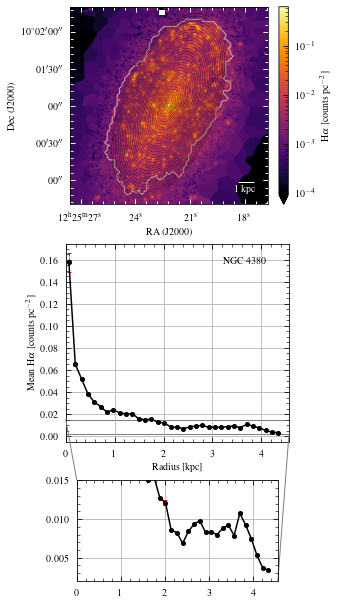

In [6]:
# 
# Plot radial profile (linear y-axis)
#
imshow_data = galaxy_rp.data
imshow_data[imshow_data <= 0] = np.min(imshow_data[imshow_data > 0])  # i.e., only show holes in LogNorm() where we actually mask data
# 
fig = plt.figure(figsize=mpl.figure.figaspect(2))
ax1 = fig.add_subplot(2, 1, 1, projection=Halpha_wcs)
img1 = ax1.imshow(
    imshow_data,
    cmap="inferno",
    norm=mpl.colors.LogNorm(vmin=np.percentile(galaxy_rp.data[np.isfinite(galaxy_rp.data)], 5)),
)
cbar1 = fig.colorbar(img1, fraction=0.045, extend="min")
cbar1.set_label(r"$\rm H\alpha$ [$\rm counts\; pc^{-2}$]")
# cbar1.set_label(r"$\rm H\alpha$ Counts")
# 
# Plot annuli
# 
ax1.plot(*Halpha_wcs.world_to_pixel(CENTER), "co", markersize=1)  # mark centre
pu.add_annuli_RadialProfile(
    ax1, galaxy_rp, ls="-", edgecolor="k", fc="None", lw=0.25, zorder=2, alpha_coeff=-1
)
#
# Add scalebar
#
pu.add_scalebar(ax1, Halpha_wcs, dist=GALDIST, size_vertical=0.25, color="w")
# 
# Add CO contour
# 
co_palette = sns.color_palette("ch:s=-.2,r=.6")
co_9as_color = co_palette[1:5]
ax1.contour(
    Ico_data,
    transform=ax1.get_transform(co_wcs),
    levels=0,
    colors=co_9as_color,
    linewidths=1,
    zorder=1,
)
#
# Other parameters
# 
ax1.set_aspect("equal")
ax1.grid(False)
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.set_xlim(0, galaxy_rp.data.shape[1])
ax1.set_ylim(0, galaxy_rp.data.shape[0])
ax1.tick_params(color="w", which="both")
#
# Plot radial profile
# 
ax2 = fig.add_subplot(2, 1, 2)
ebar2 = ax2.errorbar(
    x=galaxy_rp.radii * px_to_kpc,
    y=galaxy_rp.avg_data,
    yerr=galaxy_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar2[-1][0].set_linestyle("--")
# 
# Add name of galaxy
# 
high_i_str = "*" if INCLINATION >= I_THRESHOLD else ""
ax2.text(
    0.9,
    0.9,
    re.sub(r"(\d+)", " \\1", GALAXY) + high_i_str,
    c="k",
    ha="right",
    transform=ax2.transAxes,
)
# 
# Other parameters
# 
ax2.set_xlim(left=0)
ax2.set_xticks([0, 1, 2, 3, 4])
ax2.set_xlabel("Radius [kpc]")
ax2.set_ylabel(
    galaxy_rp.rp_options["func"].capitalize()
    + r" $\rm H\alpha$ [$\rm counts\; pc^{-2}$]"
    # + r" $\rm H\alpha$ Count"
)
# 
# Add inset window
# 
# Create zoom window
axins2 = zoomed_inset_axes(
    ax2, 7, loc="lower center",
    bbox_to_anchor=(0.5, -0.73), bbox_transform=ax2.transAxes
)
mark_inset(ax2, axins2, loc1=2, loc2=4, fc="none", ec="0.5")
axins2.set_xlim(0, ax2.get_xlim()[1])
axins2.set_ylim(0.002, 0.015)
# Plot data in zoom window
ebar2_inset = axins2.errorbar(
    x=galaxy_rp.radii * px_to_kpc,
    y=galaxy_rp.avg_data,
    yerr=galaxy_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar2_inset[-1][0].set_linestyle("--")
pu.set_aspect(axins2, 0.5)
# 
fig.subplots_adjust(hspace=0.2)
# fig.savefig(f"{GALAXY}_vorbin_SNR{SNR_TARGET}_Halpha_radProf_34annuli.pdf")
plt.show()

Radial profile plot (log y-axis)


/arc/home/IsaacCheng/.local/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


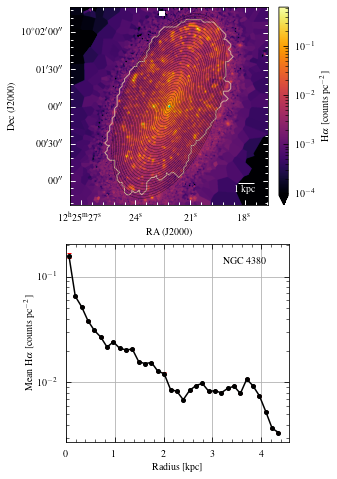

In [7]:
# 
# Plot radial profile (log y-axis)
#
imshow_data = galaxy_rp.data
imshow_data[imshow_data <= 0] = np.min(imshow_data[imshow_data > 0])  # i.e., only show holes in LogNorm() where we actually mask data
# 
fig = plt.figure(figsize=mpl.figure.figaspect(2))
ax1 = fig.add_subplot(2, 1, 1, projection=Halpha_wcs)
img1 = ax1.imshow(
    imshow_data,
    cmap="inferno",
    norm=mpl.colors.LogNorm(vmin=np.percentile(galaxy_rp.data[np.isfinite(galaxy_rp.data)], 5)),
)
cbar1 = fig.colorbar(img1, fraction=0.045, extend="min")
cbar1.set_label(r"$\rm H\alpha$ [$\rm counts\; pc^{-2}$]")
# cbar1.set_label(r"$\rm H\alpha$ Counts")
# 
# Plot annuli
# 
ax1.plot(*Halpha_wcs.world_to_pixel(CENTER), "co", markersize=1)  # mark centre
pu.add_annuli_RadialProfile(
    ax1, galaxy_rp, ls="-", edgecolor="k", fc="None", lw=0.25, zorder=2, alpha_coeff=-1
)
#
# Add scalebar
#
pu.add_scalebar(ax1, Halpha_wcs, dist=GALDIST, size_vertical=0.25, color="w")
# 
# Add CO contour
# 
co_palette = sns.color_palette("ch:s=-.2,r=.6")
co_9as_color = co_palette[1:5]
ax1.contour(
    Ico_data,
    transform=ax1.get_transform(co_wcs),
    levels=0,
    colors=co_9as_color,
    linewidths=1,
    zorder=1,
)
#
# Other parameters
# 
ax1.set_aspect("equal")
ax1.grid(False)
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.set_xlim(0, galaxy_rp.data.shape[1])
ax1.set_ylim(0, galaxy_rp.data.shape[0])
ax1.tick_params(color="w", which="both")
#
# Plot radial profile
# 
ax2 = fig.add_subplot(2, 1, 2)
ebar2 = ax2.errorbar(
    x=galaxy_rp.radii * px_to_kpc,
    y=galaxy_rp.avg_data,
    yerr=galaxy_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar2[-1][0].set_linestyle("--")
# 
# Add name of galaxy
# 
high_i_str = "*" if INCLINATION >= I_THRESHOLD else ""
ax2.text(
    0.9,
    0.9,
    re.sub(r"(\d+)", " \\1", GALAXY) + high_i_str,
    c="k",
    ha="right",
    transform=ax2.transAxes,
)
# 
# Other parameters
# 
ax2.set_xlim(left=0)
ax2.set_xticks([0, 1, 2, 3, 4])
ax2.set_xlabel("Radius [kpc]")
ax2.semilogy()
ax2.set_ylabel(
    galaxy_rp.rp_options["func"].capitalize()
    + r" $\rm H\alpha$ [$\rm counts\; pc^{-2}$]"
    # + r" $\rm H\alpha$ Count"
)
# pu.set_aspect(ax2, 0.8, logy=True)
# ax2.set_position([0.15, 0, 0.8, 0.45])
# 
# fig.savefig(f"{GALAXY}_vorbin_SNR{SNR_TARGET}_Halpha_radProf_34annuli_logy.pdf")
plt.show()

Directional radial profile


In [8]:
galaxy_drp = galaxy_rp.directional_radial_profile(
    angle=None,  # take direction to be along galaxy's major axis
    bootstrap_errs=True,
    bootstrap_seed=3141592654,
    results_to_1d=True,  # easier to plot radial profile this way
)

Directional radial profile plot (linear y-axis)


/arc/home/IsaacCheng/.local/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


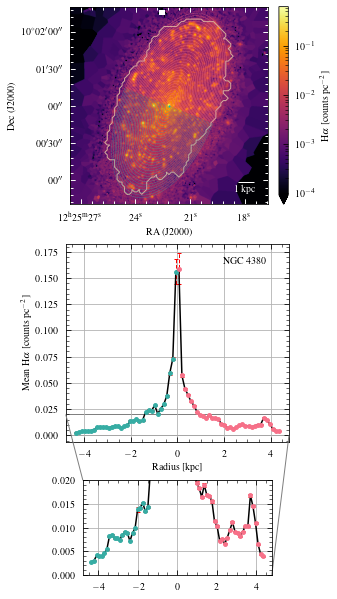

In [9]:
from matplotlib.patches import Arc
# 
# Plot directional radial profile (linear y-axis)
#
fig = plt.figure(figsize=mpl.figure.figaspect(2))
ax1 = fig.add_subplot(2, 1, 1, projection=Halpha_wcs)
positive_color = sns.color_palette("husl", 8)[0]
negative_color = sns.color_palette("husl", 8)[4]
# positive_color = sns.color_palette("Set2")[0]
# negative_color = sns.color_palette("Set2")[6]
#
# Plot data
#
imshow_data = galaxy_drp.data
imshow_data[imshow_data <= 0] = np.min(imshow_data[imshow_data > 0])  # i.e., only show holes in LogNorm() where we actually mask data
img1 = ax1.imshow(
    imshow_data,
    cmap="inferno",
    norm=mpl.colors.LogNorm(vmin=np.percentile(galaxy_drp.data[np.isfinite(galaxy_drp.data)], 5)),
)
cbar1 = fig.colorbar(img1, fraction=0.045, extend="min")
cbar1.set_label(r"$\rm H\alpha$ [$\rm counts\; pc^{-2}$]")
# Mark centre
ax1.plot(*Halpha_wcs.world_to_pixel(CENTER), "co", markersize=1)
# Add annuli
annuli = np.hstack((galaxy_drp.annuli[::-1], galaxy_drp.annuli))
for num, annulus in enumerate(annuli):
    try:
        # EllipticalAnnulus attributes. N.B. height and width are switched from "normal"
        height = annulus.b_out
        width = annulus.a_out
    except AttributeError:
        # EllipticalAperture attributes. N.B. height and width are switched from "normal"
        height = annulus.b
        width = annulus.a
    if num >= len(annuli) / 2:
        # Positive radii annuli
        edgecolor = positive_color
        arcangle = (np.rad2deg(annulus.theta) + 180) % 360.0
    else:
        # Negative radii annuli
        edgecolor = negative_color
        arcangle = np.rad2deg(annulus.theta) % 360.0
    arc = Arc(
        xy=annulus.positions,
        width=width * 2,  # full major/minor axis
        height=height * 2,  # full major/minor axis
        angle=arcangle,
        theta1=-90,
        theta2=90,
        ls="-",
        edgecolor=edgecolor,
        alpha=1,
        lw=0.25,
        zorder=2,
    )
    ax1.add_patch(arc)
#
# Add scalebar
#
pu.add_scalebar(ax1, Halpha_wcs, dist=GALDIST, size_vertical=0.25, color="w")
# 
# Add CO contour
# 
co_palette = sns.color_palette("ch:s=-.2,r=.6")
co_9as_color = co_palette[1:5]
ax1.contour(
    Ico_data,
    transform=ax1.get_transform(co_wcs),
    levels=0,
    colors=co_9as_color,
    linewidths=1,
    zorder=1,
)
#
# Other parameters
# 
ax1.set_xlim(0, galaxy_drp.data.shape[1])
ax1.set_ylim(0, galaxy_drp.data.shape[0])
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.grid(False)
ax1.set_aspect("equal")
ax1.tick_params(which="both", color="w")
#
ax2 = fig.add_subplot(2, 1, 2)
radii = galaxy_drp.drp_results["radii"]
# Plot negative radii data
ax2.scatter(
    x=radii[radii < 0] * px_to_kpc,
    y=galaxy_drp.drp_results["avg_data"][radii < 0],
    color=negative_color,
    s=15,
    zorder=3,
)
# Plot positive radii data
ax2.scatter(
    x=radii[radii > 0] * px_to_kpc,
    y=galaxy_drp.drp_results["avg_data"][radii > 0],
    color=positive_color,
    s=15,
    zorder=3,
)
# Plot errorbars
ebar2 = ax2.errorbar(
    x=galaxy_drp.drp_results["radii"] * px_to_kpc,
    y=galaxy_drp.drp_results["avg_data"],
    yerr=galaxy_drp.drp_results["avg_data_err"],  # uncertainty from bootstrapping
    fmt="-",
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar2[-1][0].set_linestyle("--")
# 
# Add name of galaxy
# 
high_i_str = "*" if galaxy_drp.i >= I_THRESHOLD else ""
ax2.text(
    0.9,
    0.9,
    re.sub(r"(\d+)", " \\1", GALAXY) + high_i_str,
    c="k",
    ha="right",
    transform=ax2.transAxes,
)
ax2.set_xticks([-4, -2, 0, 2, 4])
ax2.set_xlabel("Radius [kpc]")
ax2.set_ylabel(
    galaxy_rp.rp_options["func"].capitalize()
    + r" $\rm H\alpha$ [$\rm counts\; pc^{-2}$]"
    # + r" $\rm H\alpha$ Count"
)
# 
# Add inset window
# 
# Create zoom window
axins2 = zoomed_inset_axes(ax2, 4.5, loc="lower center", bbox_to_anchor=(0.5, -0.7), bbox_transform=ax2.transAxes)
mark_inset(ax2, axins2, loc1=2, loc2=4, fc="none", ec="0.5")
axins2.set_ylim(top=0.02)
# Plot data in zoom window
# Plot negative radii data
axins2.scatter(
    x=radii[radii < 0] * px_to_kpc,
    y=galaxy_drp.drp_results["avg_data"][radii < 0],
    color=negative_color,
    s=15,
    zorder=3,
)
# Plot positive radii data
axins2.scatter(
    x=radii[radii > 0] * px_to_kpc,
    y=galaxy_drp.drp_results["avg_data"][radii > 0],
    color=positive_color,
    s=15,
    zorder=3,
)
# Plot errorbars
ebar2_inset = axins2.errorbar(
    x=galaxy_drp.drp_results["radii"] * px_to_kpc,
    y=galaxy_drp.drp_results["avg_data"],
    yerr=galaxy_drp.drp_results["avg_data_err"],  # uncertainty from bootstrapping
    fmt="-",
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar2_inset[-1][0].set_linestyle("--")
# ax2.indicate_inset_zoom(axins2)
pu.set_aspect(axins2, 0.5)
#
fig.subplots_adjust(hspace=0.2)
# fig.savefig(f"{GALAXY}_vorbin_SNR{SNR_TARGET}_Halpha_directionalRadProf_34annuli.pdf")
plt.show()

Directional radial profile plot (log y-axis)


/arc/home/IsaacCheng/.local/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


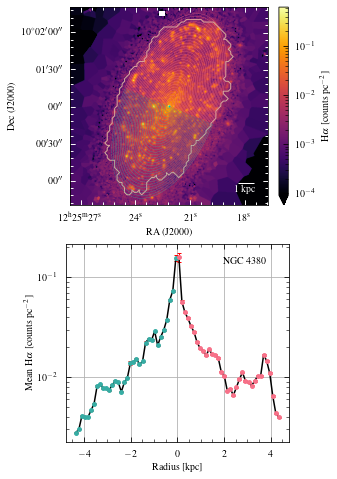

In [10]:
from matplotlib.patches import Arc
# 
# Plot directional radial profile (log y-axis)
#
fig = plt.figure(figsize=mpl.figure.figaspect(2))
ax1 = fig.add_subplot(2, 1, 1, projection=Halpha_wcs)
positive_color = sns.color_palette("husl", 8)[0]
negative_color = sns.color_palette("husl", 8)[4]
# positive_color = sns.color_palette("Set2")[0]
# negative_color = sns.color_palette("Set2")[6]
#
# Plot data
#
imshow_data = galaxy_drp.data
imshow_data[imshow_data <= 0] = np.min(imshow_data[imshow_data > 0])  # i.e., only show holes in LogNorm() where we actually mask data
img1 = ax1.imshow(
    imshow_data,
    cmap="inferno",
    norm=mpl.colors.LogNorm(vmin=np.percentile(galaxy_drp.data[np.isfinite(galaxy_drp.data)], 5)),
)
cbar1 = fig.colorbar(img1, fraction=0.045, extend="min")
cbar1.set_label(r"$\rm H\alpha$ [$\rm counts\; pc^{-2}$]")
# Mark centre
ax1.plot(*Halpha_wcs.world_to_pixel(CENTER), "co", markersize=1)
# Add annuli
annuli = np.hstack((galaxy_drp.annuli[::-1], galaxy_drp.annuli))
for num, annulus in enumerate(annuli):
    try:
        # EllipticalAnnulus attributes. N.B. height and width are switched from "normal"
        height = annulus.b_out
        width = annulus.a_out
    except AttributeError:
        # EllipticalAperture attributes. N.B. height and width are switched from "normal"
        height = annulus.b
        width = annulus.a
    if num >= len(annuli) / 2:
        # Positive radii annuli
        edgecolor = positive_color
        arcangle = (np.rad2deg(annulus.theta) + 180) % 360.0
    else:
        # Negative radii annuli
        edgecolor = negative_color
        arcangle = np.rad2deg(annulus.theta) % 360.0
    arc = Arc(
        xy=annulus.positions,
        width=width * 2,  # full major/minor axis
        height=height * 2,  # full major/minor axis
        angle=arcangle,
        theta1=-90,
        theta2=90,
        ls="-",
        edgecolor=edgecolor,
        alpha=1,
        lw=0.25,
        zorder=2,
    )
    ax1.add_patch(arc)
#
# Add scalebar
#
pu.add_scalebar(ax1, Halpha_wcs, dist=GALDIST, size_vertical=0.25, color="w")
# 
# Add CO contour
# 
co_palette = sns.color_palette("ch:s=-.2,r=.6")
co_9as_color = co_palette[1:5]
ax1.contour(
    Ico_data,
    transform=ax1.get_transform(co_wcs),
    levels=0,
    colors=co_9as_color,
    linewidths=1,
    zorder=1,
)
#
# Other parameters
# 
ax1.set_xlim(0, galaxy_drp.data.shape[1])
ax1.set_ylim(0, galaxy_drp.data.shape[0])
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.grid(False)
ax1.set_aspect("equal")
ax1.tick_params(which="both", color="w")
#
ax2 = fig.add_subplot(2, 1, 2)
radii = galaxy_drp.drp_results["radii"]
# Plot negative radii data
ax2.scatter(
    x=radii[radii < 0] * px_to_kpc,
    y=galaxy_drp.drp_results["avg_data"][radii < 0],
    color=negative_color,
    s=15,
    zorder=3,
)
# Plot positive radii data
ax2.scatter(
    x=radii[radii > 0] * px_to_kpc,
    y=galaxy_drp.drp_results["avg_data"][radii > 0],
    color=positive_color,
    s=15,
    zorder=3,
)
# Plot errorbars
ebar2 = ax2.errorbar(
    x=galaxy_drp.drp_results["radii"] * px_to_kpc,
    y=galaxy_drp.drp_results["avg_data"],
    yerr=galaxy_drp.drp_results["avg_data_err"],  # uncertainty from bootstrapping
    fmt="-",
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar2[-1][0].set_linestyle("--")
# 
# Add name of galaxy
# 
high_i_str = "*" if galaxy_drp.i >= I_THRESHOLD else ""
ax2.text(
    0.9,
    0.9,
    re.sub(r"(\d+)", " \\1", GALAXY) + high_i_str,
    c="k",
    ha="right",
    transform=ax2.transAxes,
)
ax2.set_xticks([-4, -2, 0, 2, 4])
ax2.set_xlabel("Radius [kpc]")
ax2.semilogy()
ax2.set_ylabel(
    galaxy_rp.rp_options["func"].capitalize()
    + r" $\rm H\alpha$ [$\rm counts\; pc^{-2}$]"
    # + r" $\rm H\alpha$ Count"
)
#
# fig.savefig(f"{GALAXY}_vorbin_SNR{SNR_TARGET}_Halpha_directionalRadProf_34annuli_logy.pdf")
plt.show()